캬.... 아주 멋있는 사람이 기본적인 케라스를 활용해서 이 문제를 해결하는 방법에 대한 노트북을 만들어놨네요.   
keras LSTM을 사용해서 할 예정이라고 하고요, 초보자들을 위해 만드셨대요. 박수~

일단 기본 케라스 라이브러리를 불러와 봅시다. 

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

파일 불러올게여

In [2]:
train = pd.read_csv('/Users/apstat/Desktop/ALCP/KAGGLE 필사/Toxic comment/train.csv')
test = pd.read_csv('/Users/apstat/Desktop/ALCP/KAGGLE 필사/Toxic comment/test.csv')

데이터 함 볼까요?

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


자 그럼 null값이 있나 볼까요?

In [4]:
train.isnull().any(),test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool,
 id              False
 comment_text    False
 dtype: bool)

없네요~

일단 오늘은 전처리를 빡세게는 안할거라고 하네요~

종속변수가 훈련 세트에 있어서 일단 거기있는 데이터를 x랑 y로 나눠야한대요.

In [5]:
list_classes = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[list_classes].values
list_sentences_train = train['comment_text']
list_sentences_test = test['comment_text']

이게 약간 이제 신경망을 사용할건데, LSTM에 댓글을 입력해서 사용하는건데, 이제 이게 단어를 그대로 쓸수가 없잖아요?   
그래서 토큰화(단어단위로 자르기)하고, 인덱싱을 할거래요   
그럼 이 인ㄷ게스 표현으로 댓글을 나타낼 수 있겠죠?

케라스에서는 이 모든 단계를 쉽게 만들어놨대요!   
근데, 문장을 토큰화할 때는 단어의 최대 개수를 정해야한대요   
밑에서는 20000개로 설정했나봐요

In [6]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts (list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [7]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

근데 여기서 문제가 생기는게 뭐냐면, 댓글마다 길이가 다르니까 댓글별로 인덱스로 이루어진 리스트의 길이가 달라지겠죠?   
그래서 패딩을 사용한대요. 부족한거를 0으로 채워서 길이를 일정하게하고, 만약에 문장이 개길다? 그럼 최대길이에 맞춰서 잘라버리는거죠   
여기서는 200으로 설정했대여

In [76]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

이 최대 길이를 너무 짧게 설정하면 정확도가 떨어지고, 너무 길어져버리면 아마 속도가 느리겠죠?   
그래서 일단 문장에서 단어 분포를 봐볼게여

In [9]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

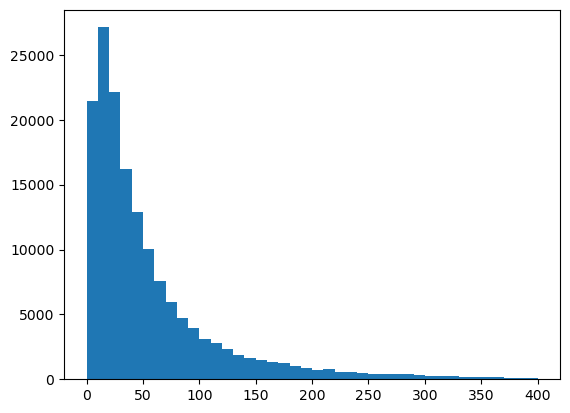

In [10]:
plt.hist(totalNumWords, bins=np.arange(0,410,10))
plt.show()

대부분이 한 100개 언더에서 끊기니께, 200개로 잘라도 되겠죠?  
뭐 다른 숫자로 해도 상관없을거같긴한데, 여기서 이렇게 하라니까 하란대로 할게여~  

이제 모델 설계한대요..ㄷ

![](https://i.imgur.com/txJomEa.png)

1. input layer   
각 문장들을 길이 200의 정수 시퀀스로 표현   
(None은 batch size로 학습시 자동으로 결정됨)

In [12]:
# 200개의 정수 시퀀스
inp = Input(shape=(maxlen, ))

2. embedding layer   
각 단어들을 128차원으로 임베딩. 200개의 단어 각각이 128차원으로 바뀜   
문장은 (200, 128) 형태로 변함   
네트워크가 “단어의 의미 공간”을 학습하는 단계.   
이 학습을 통해 단어 간 의미적 유사성이 벡터공간에서 반영되고, 단어들은 벡터공간의 특정 좌표에 위치함.   
차원은 단어를 얼마나 정교하게 표현할지를 결정하는 하이퍼파라미터.   
차원이 늘어나면, 다른 단어들과 구분할 수 있는 요소가 늘어나는거니까 더 정교하게 비교하는거겠지?   

In [13]:
# 128차원으로 임베딩
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

3. LSTM layer   
시퀀스의 각 시점마다 60차원의 출력을 생성.    
128차원의 임베딩을 받아서 60차원의 새로운 출력 벡터를 생성.   
Embedding - 단어의 기본 의미를 담은 벡터   
LSTM 출력 - 문맥을 반영해 의미를 재구성한 벡터   
  
return_state   
True : 모든 단어들의 의미있는 표현 (각 단어별로 시점별 출력 유지)   
False : 전체 문장을 하나의 의미 벡터로 요약 (마지막 단어의 출력 벡터만)   
=> 하지만 결국엔 마지막 단어는 이전 단어들과의 유기적인 연결이되어있으므로, 마지막 단어에도 문장 전체의 정보가 담겨있음.   
  
딥러닝 모델에서는 텍스트를 처리할 때   
문장 수 × 단어 수 × 단어 벡터 차원    
으로 데이터를 보기 때문에 자연스럽게 3차원 텐서가 됩니다.   
 
LSTM은?   
Long Short Term Memory. 순환신경망의 일종. 문장처럼 순서가 중요한 데이터를 다룰때 유용. 과거의 데이터도 기억을 함.   
문장의 경우에는 앞에 나온 맥락에 따라서 의미가 다르게 해석될 수 있는 경우가 있음.   
일반 RNN은 과거의 정보가 금방 사라지기 떄문에 긴 문장을 처리할때 기울기 소실 문제로 학습이 잘 안됨.   
LSTM은 기억셀과 게이트 구조를 통해 이러한 문제를 해결   
 
기억셀 : 중요한 정보를 길게 유지하는 통로   
입력 게이트 : 새 정보를 얼마나 기억   
포겟 게이트 : 이전 정보를 얼마나 잊을지   
출력 게이트 : 현재 셀의 정보를 얼마나 다음셀로 보낼지.   
 

밑에 그림을 보면 x(단어)를 입력하면 128차원 임베딩 층 A를 거쳐서 60차원 h벡터가 출력되고, 그게 단어의 길이(200)만큼 반복된다는 말

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

In [15]:
# 60차원 lstm, 출력내용 기억, 이름설정?
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

4. Global Max Pooling
타임스텝 200개 중 각 feature(60개)에 대해 최댓값만 선택   
결과적으로 한 문장은 60차원 벡터로 압축됨.   
(None, 200, 60) -> (None,60)   
200개중 최댓값이 2차원의 60개로 들어감.   

타입스텝 200개중 최댓값이 갖는 의미 :   
각 feature(예: 60개) 중 하나는 어떤 개념/의미를 학습하고,   
그 feature의 200개 값 중 최댓값 하나는   
“이 문장에서 그 의미가 얼마나 강하게 나타났는가“를 나타내는 수치   

여기서 feature 60개는 각 단어가 가진 의미 표현의 차원 수인거고, 200개는 문장의 단어수임.   
그래서 60개의 의미표현에 대해서 단어 200개 중에 가장 큰 값을 갖는 값을 대표값?으로 사용함. 근데, 그 단어가 뭔지는 모르는거지.

In [16]:
# GlobalMaxpooling
x = GlobalMaxPool1D()(x)

5. Dropout
과적합 방지를 위한 무작위 뉴런 끄기.   
학습할때 일부 뉴런들을 랜덤으로 꺼서 모델이 데이터를 너무 외워서 과적합이 되는걸 방지함.   
학습할때만 적용되고, 테스트할때는 모든 뉴런을 사용해서 예측

In [17]:
# 10% 끄기
x = Dropout(0.1)(x)

6. Dense → Dropout → Dense (최종 분류)   
Dense(50): 60차원 벡터의 입력값을 받아서 50개의 뉴런에 각각 연결, 50차원의 출력 벡터 생성   
=> 50개의 뉴런 각각의 가중합을 계산하고, 비선형 활성화 함수(ReLU)를 거쳐 특정 패턴을 추출   
Dropout : Dense(50)에서 받은 패턴을 뉴런을 꺼가면서 학습   
Dense(6) : 마지막 출력층으로 최종적으로 문장이 6개 중 어떤 클래스에 속하는지 예측. 보통 softmax함수를 사용.

In [18]:
# ReLU사용
x = Dense(50, activation="relu")(x)

In [19]:
# dropout 한번 더
x = Dropout(0.1)(x)

In [20]:
# 6개 클래스로 축소
# x = Dense(6, activation="sigmoid")(x) 

In [27]:
# 이진분류인데 왜 6개임?
x = Dense(6, activation="sigmoid")(x) 

![](https://i.imgur.com/uSjU4J7.png)
대충 이런식으로 입력이 들어간다~! number of samples는 위에서 말한 batch size 인듯?

In [34]:
print(X_t.shape, y.shape)
print(y)

(159571, 200) (159571, 6)
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


주어진 모델

In [39]:
# 모델 설정할게요
# 추가 지표 설정
from tensorflow.keras.metrics import AUC, Precision, Recall

model1 = Model(inputs=inp, outputs=x)
model1.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy', Precision(), Recall(), AUC()])

In [41]:
batch_size = 32
epochs = 2
model1.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 178s 40ms/step - accuracy: 0.9942 - auc: 0.7499 - loss: 0.1414 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9940 - val_auc: 0.7510 - val_loss: 0.1423 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/2
4488/4488 ━━━━━━━━━━━━━━━━━━━━ 179s 40ms/step - accuracy: 0.9938 - auc: 0.7504 - loss: 0.1416 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.9940 - val_auc: 0.7525 - val_loss: 0.1422 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


왜 precision이랑 recall 이 0이지? => 양성으로 예측한게 없는건가?

accuracy : 전체 샘플 중 정답을 맞춘 비율   
precision : 맞다고 예측한 것 중 실제로 맞은 비율   
recall : 실제로 맞아야 하는것 중 맞춘 비율   
auc : roc곡선 아래 면적   
f1 : 2 x (precision x recall) / (precision + recall)   

정답 클래스의 확률이 높을수록 → 낮은 loss   
정답이긴 한데 불확실하게 찍은 경우(클래스별 확률 차이가 크지 않음) → 높은 loss   
틀렸는데 엄청 확신한 경우(이건 뭐 쓰레기지) → 더 높은 loss   

=> 정확도도 중요하지만, loss가 큰 경우에는 조심해야 한다...

In [37]:
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 200, 60)        │        45,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 60)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 50)             │         3,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,825,421 (29.85 MB)

 Trainable params: 2,608,473 (9.95 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,216,948 (19.90 MB)

모르겟음............. 걍 반쪽짜리임...